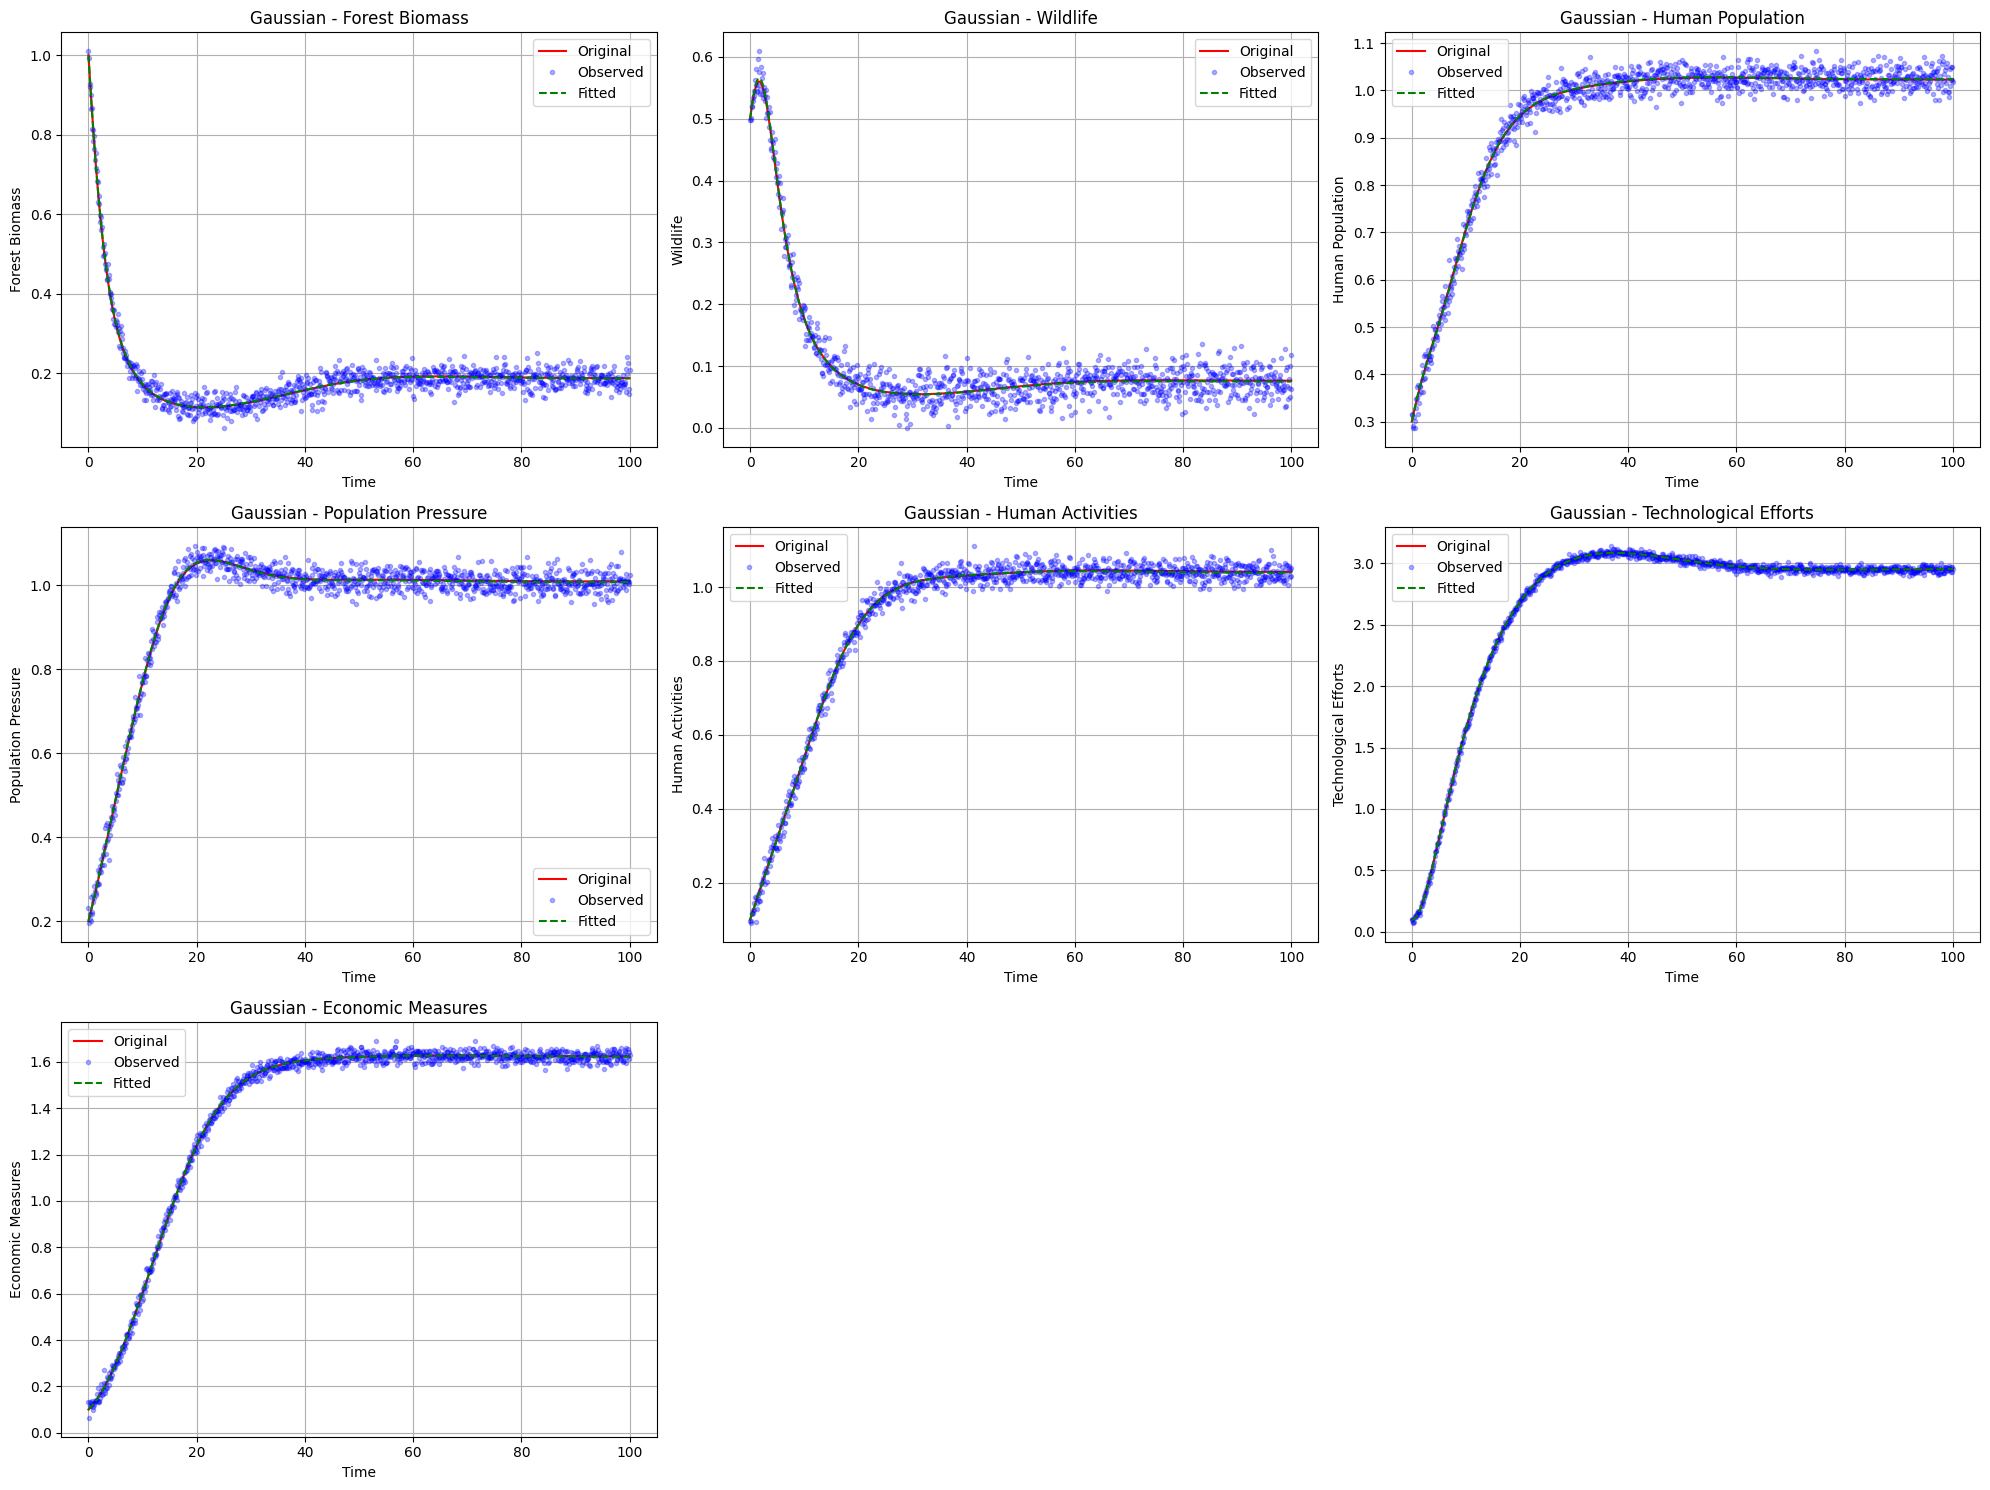

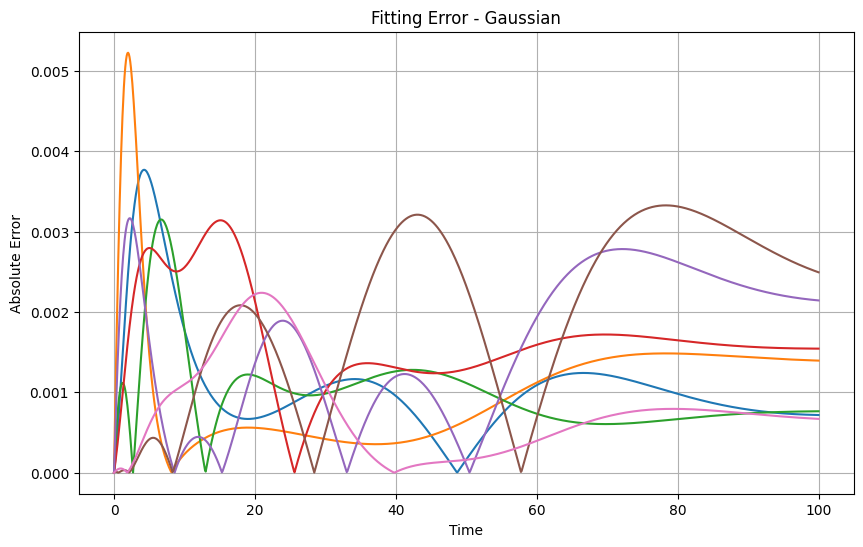

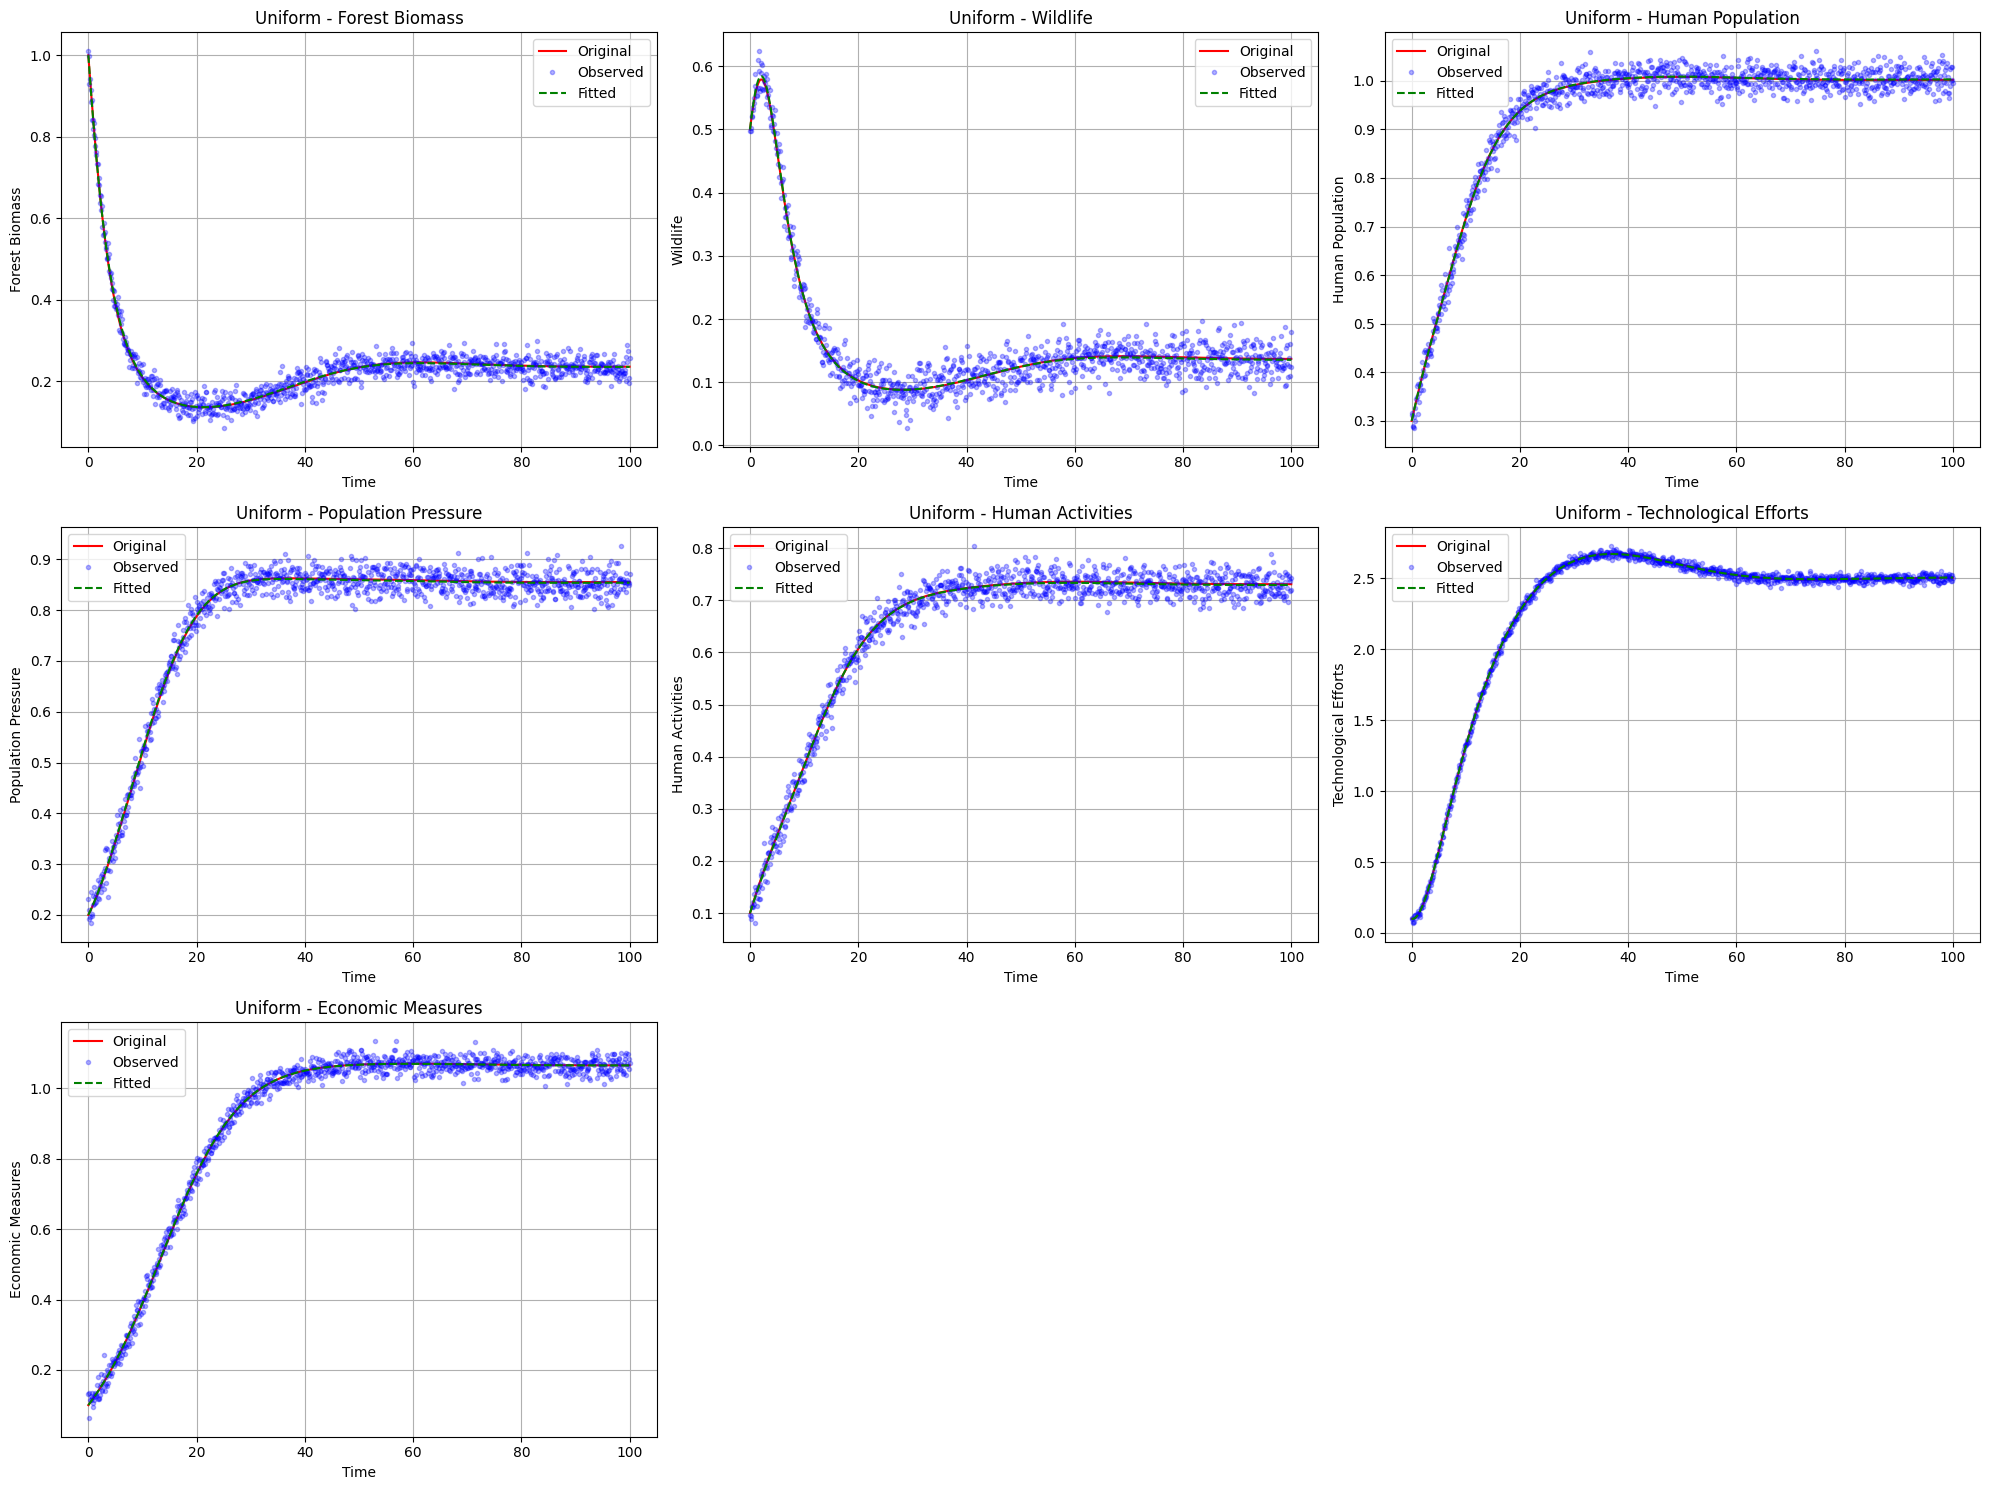

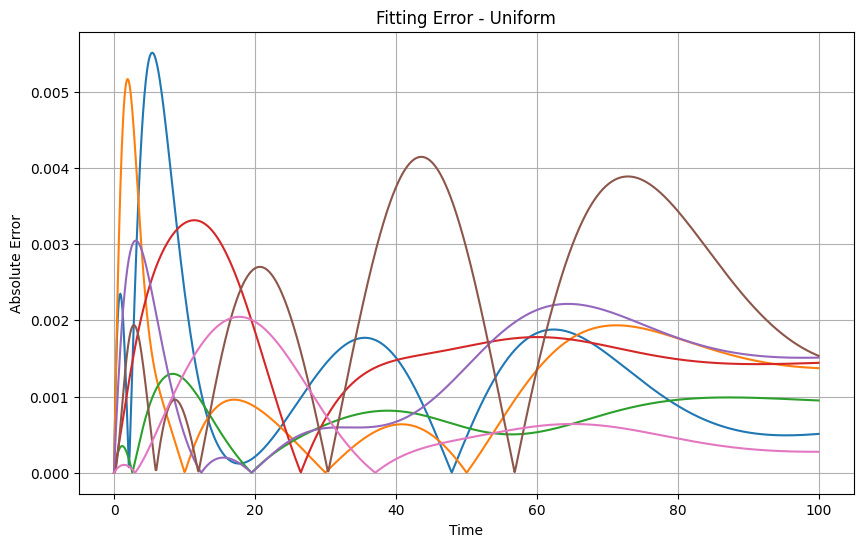

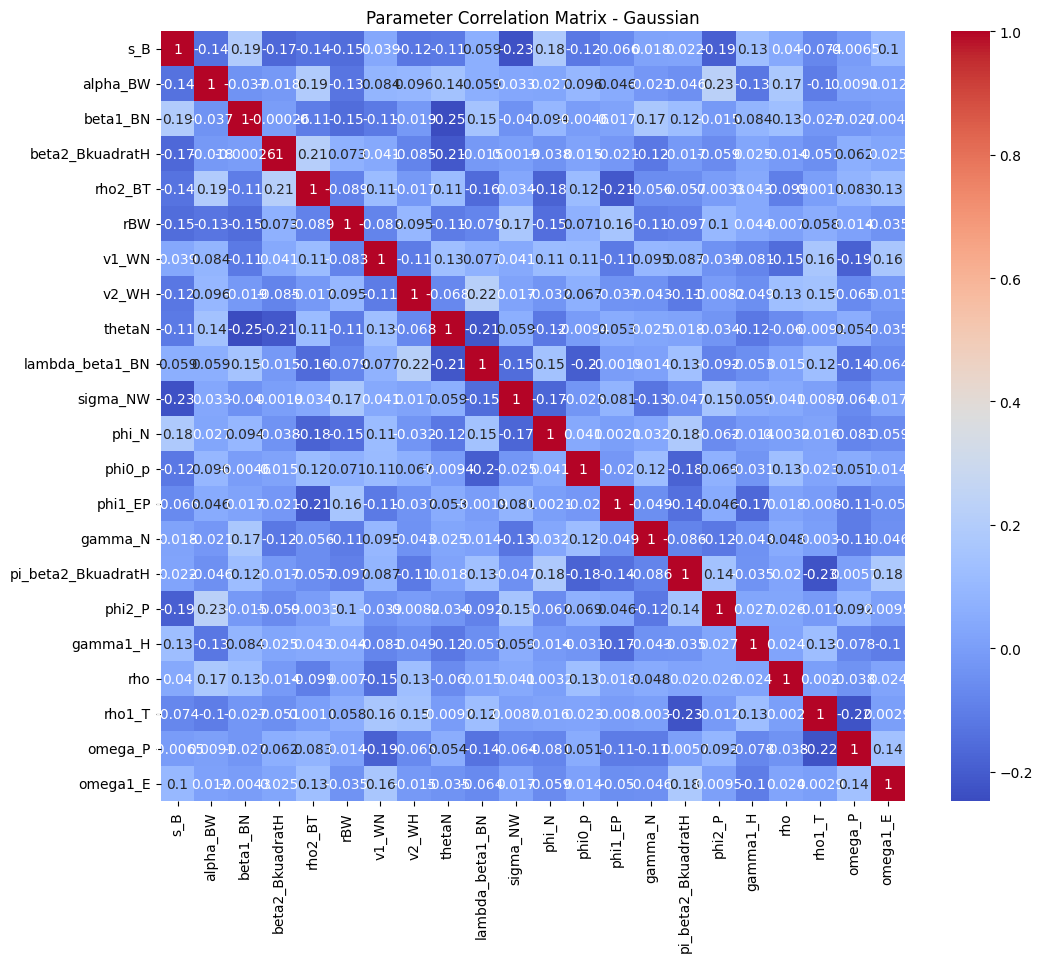

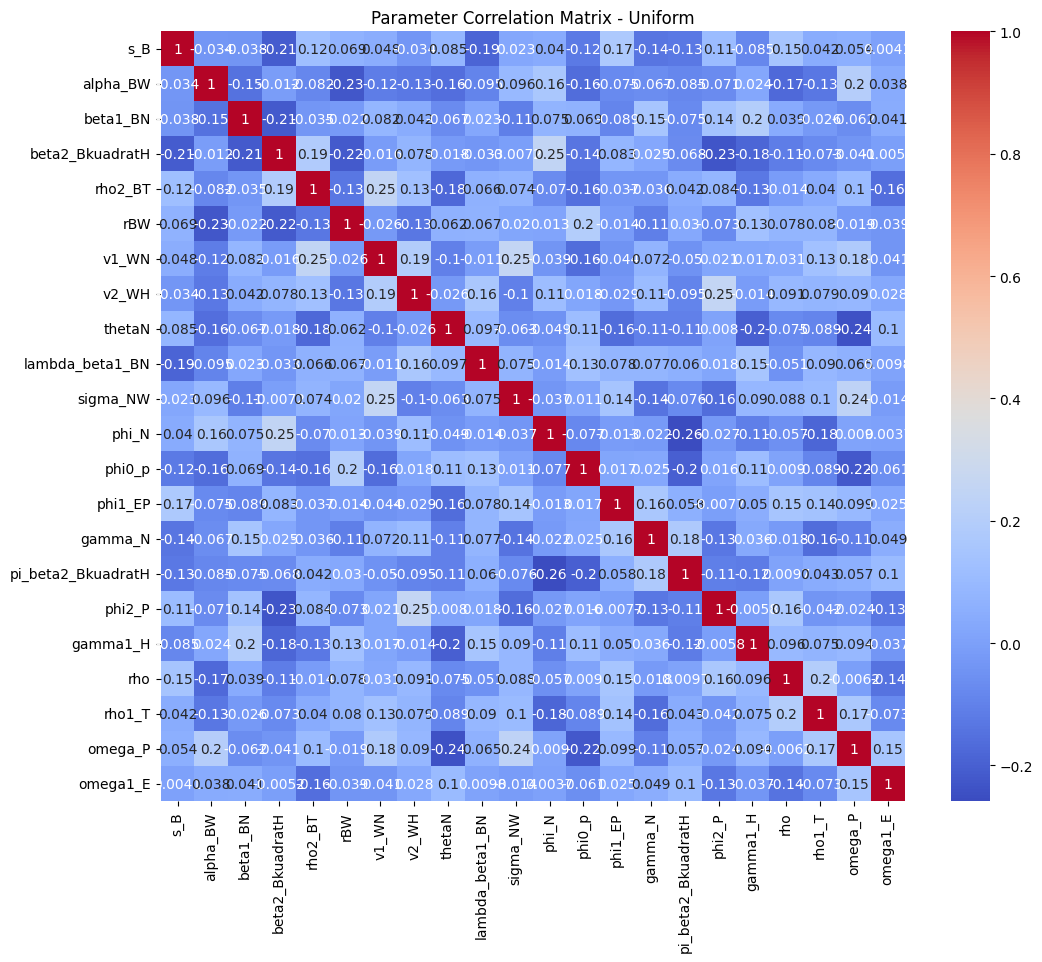

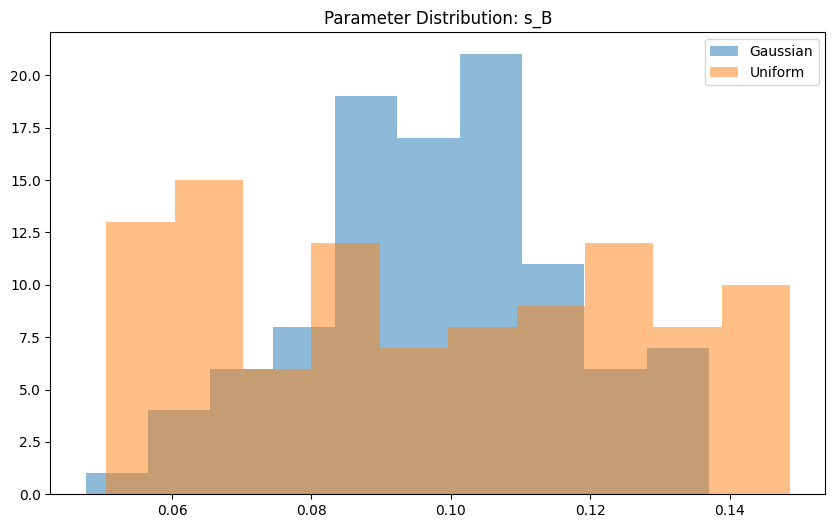

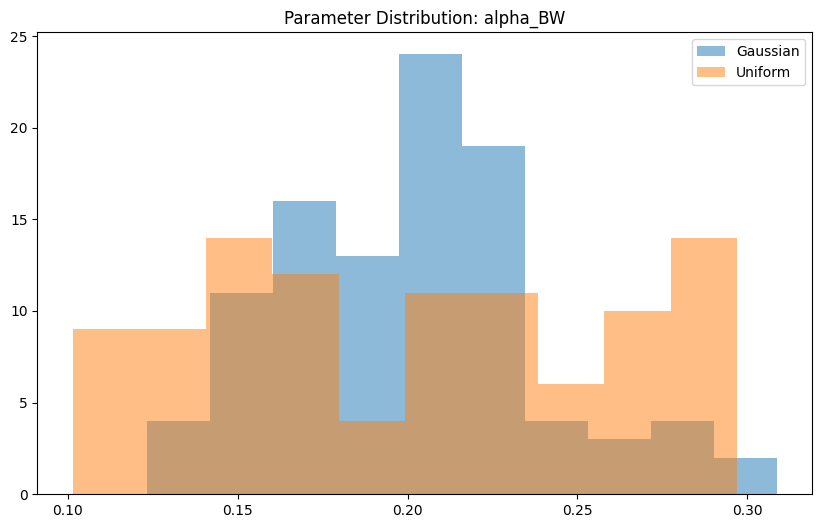

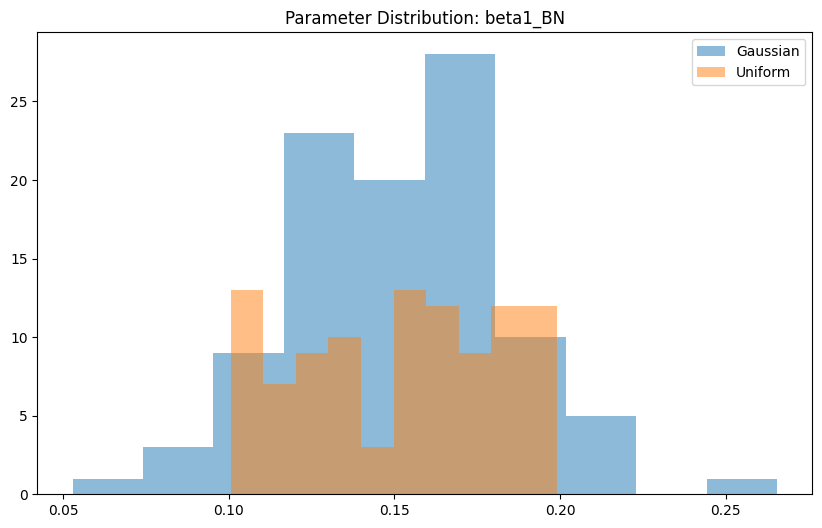

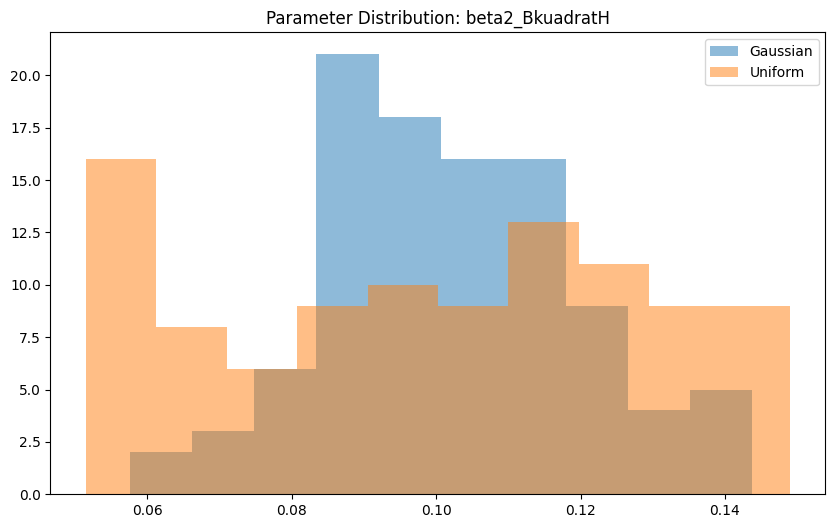

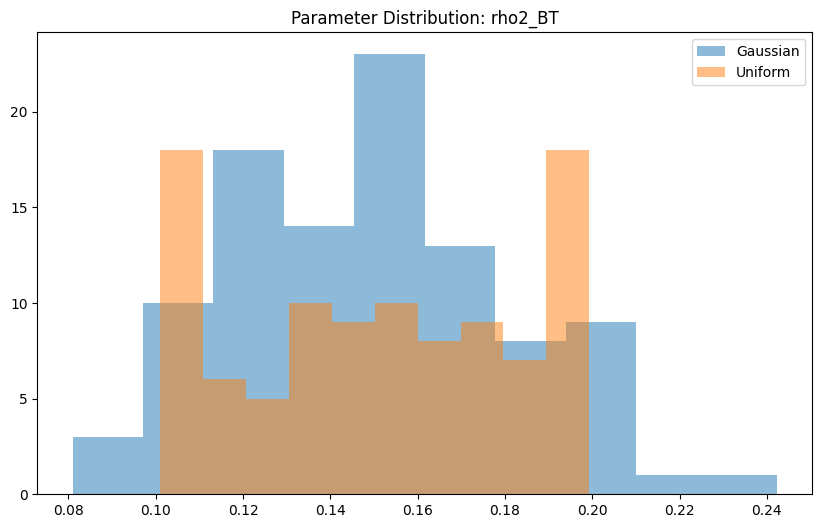

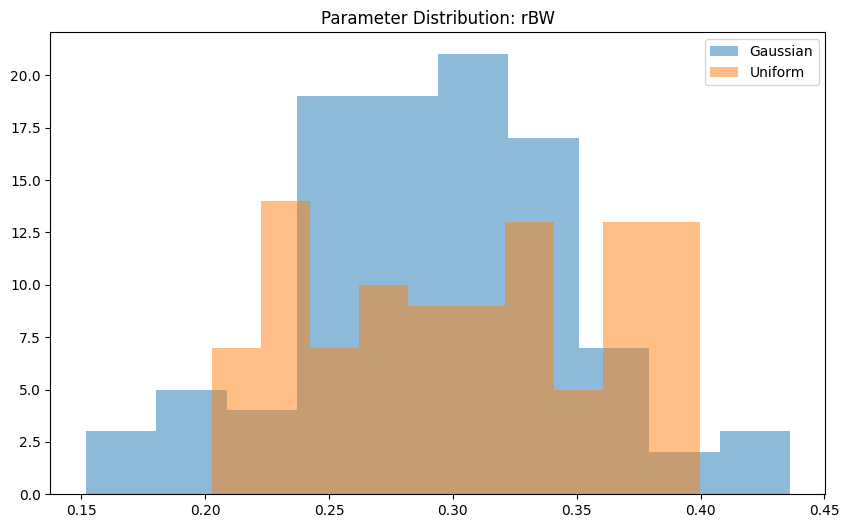

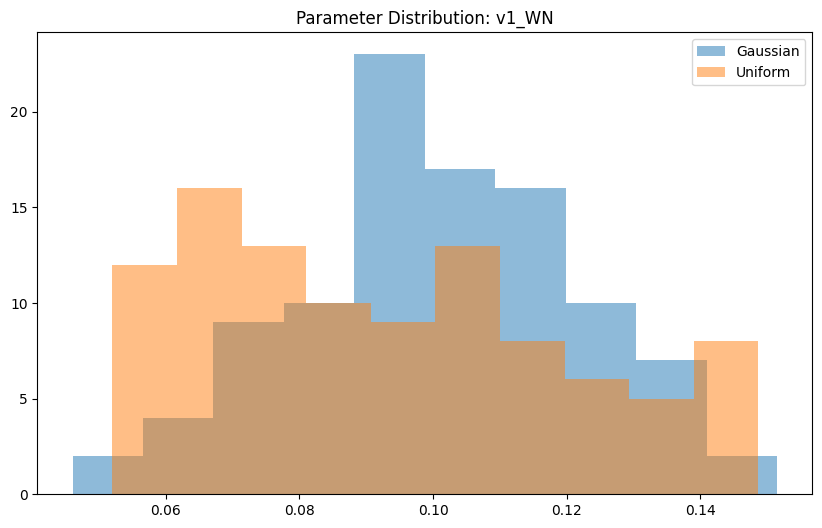

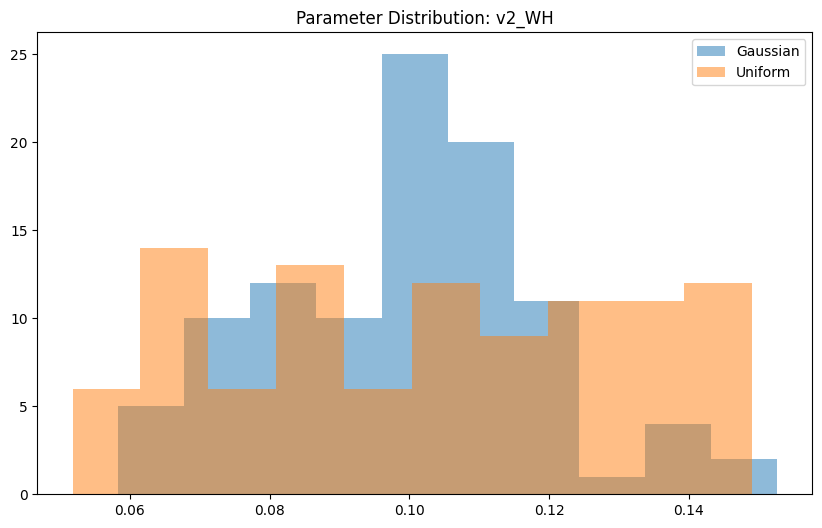

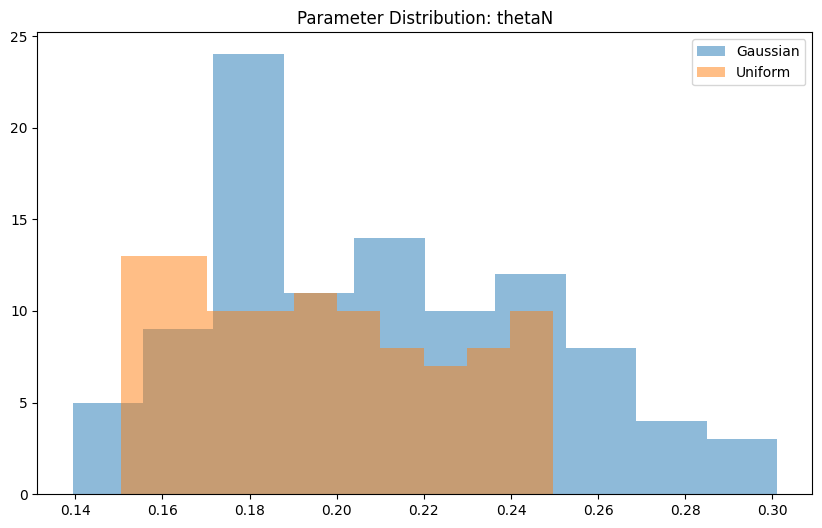

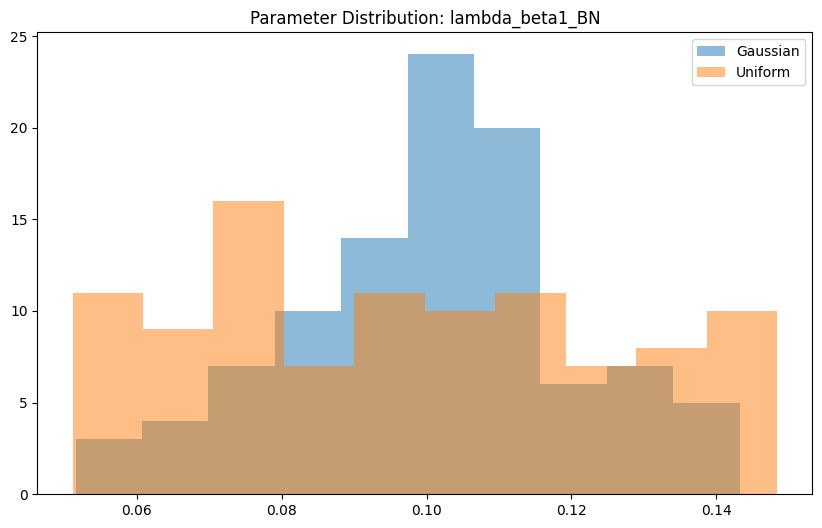

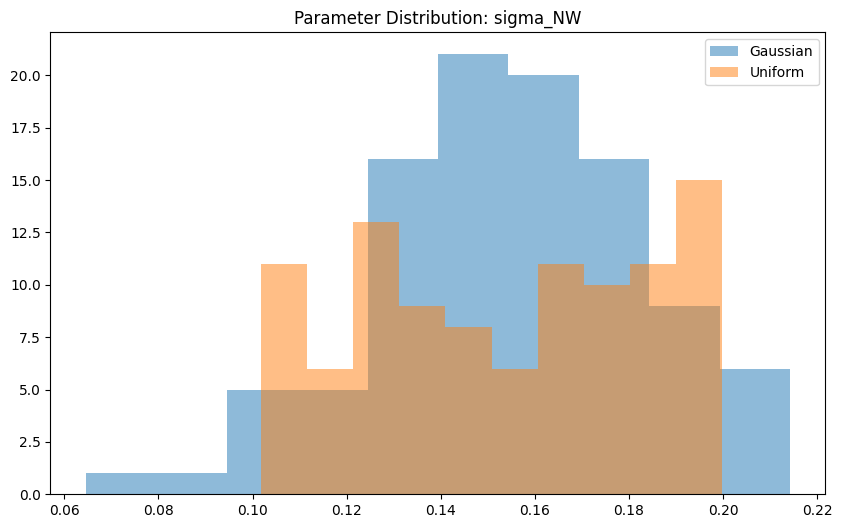

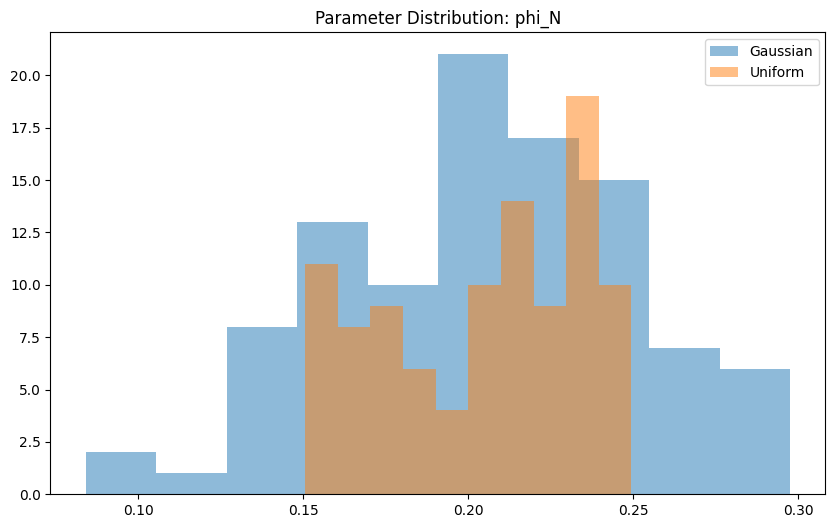

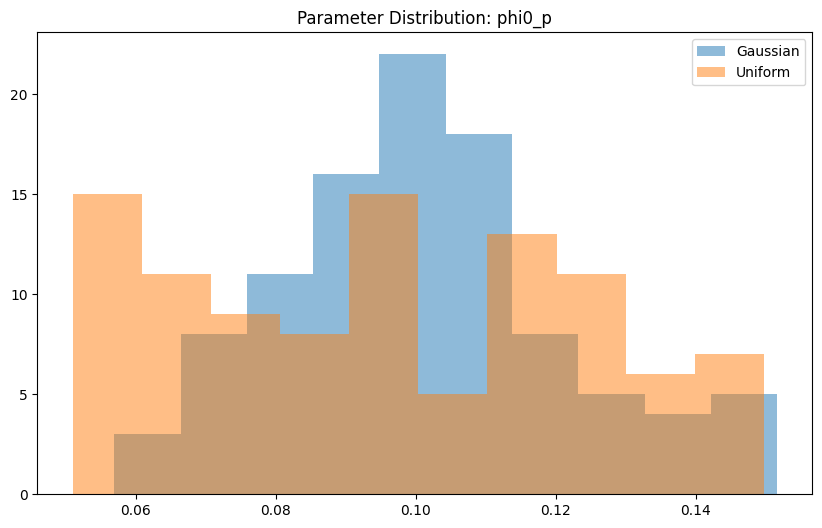

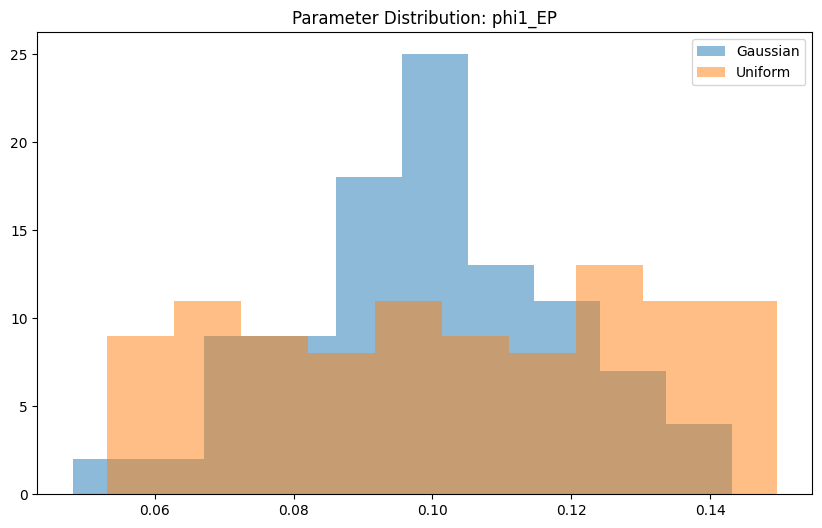

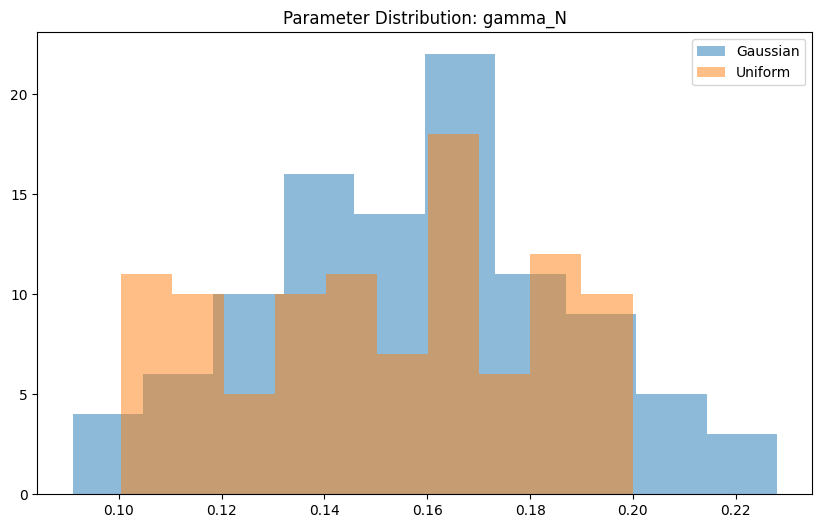

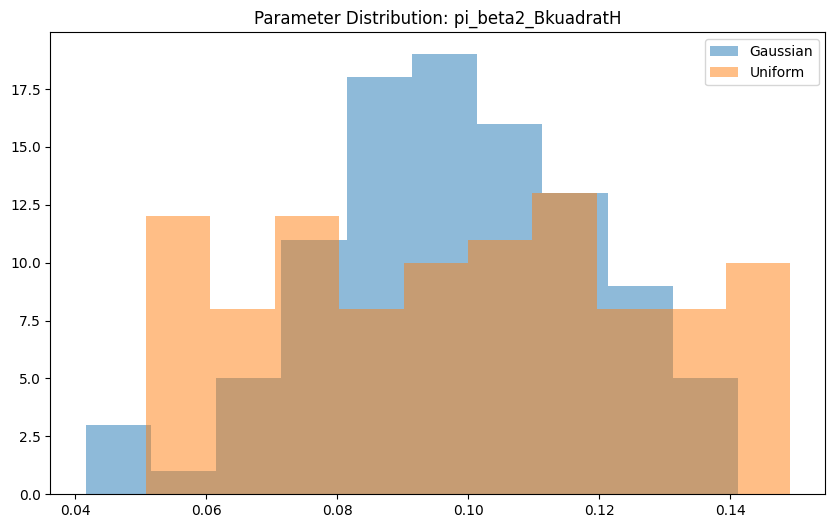

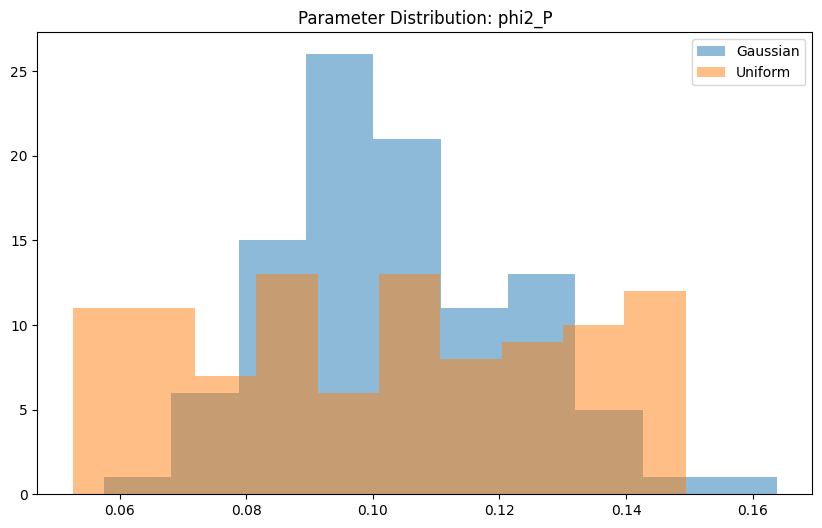

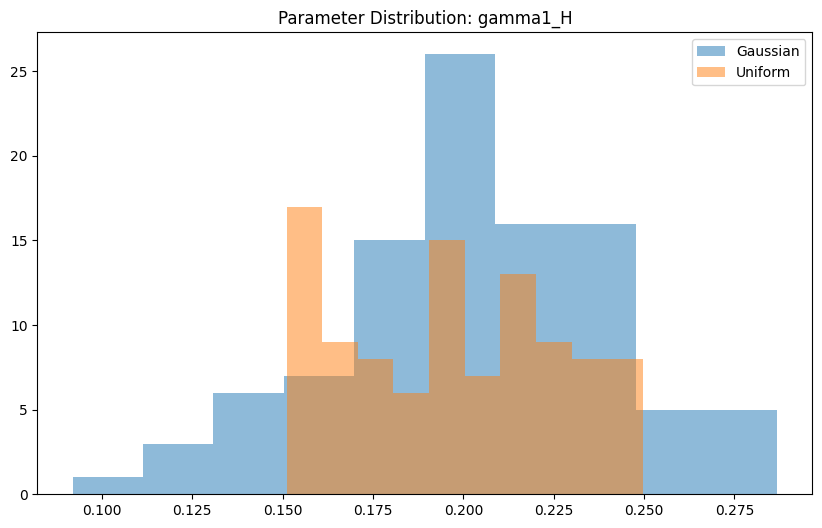

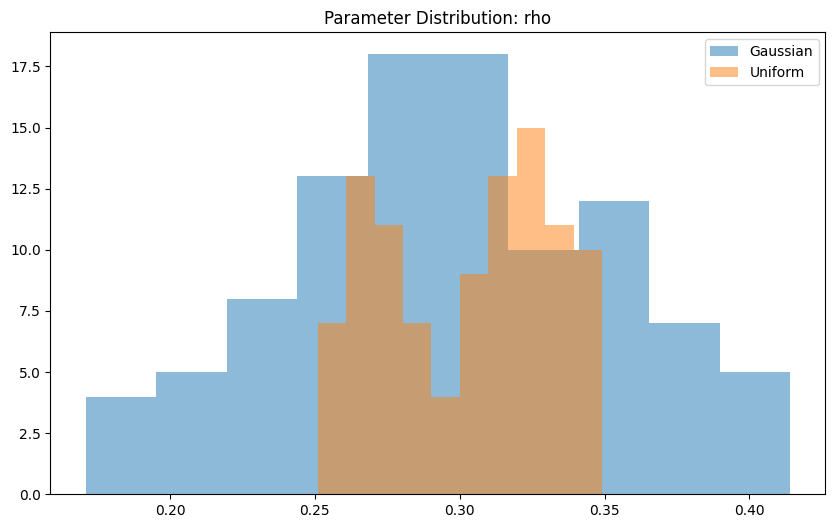

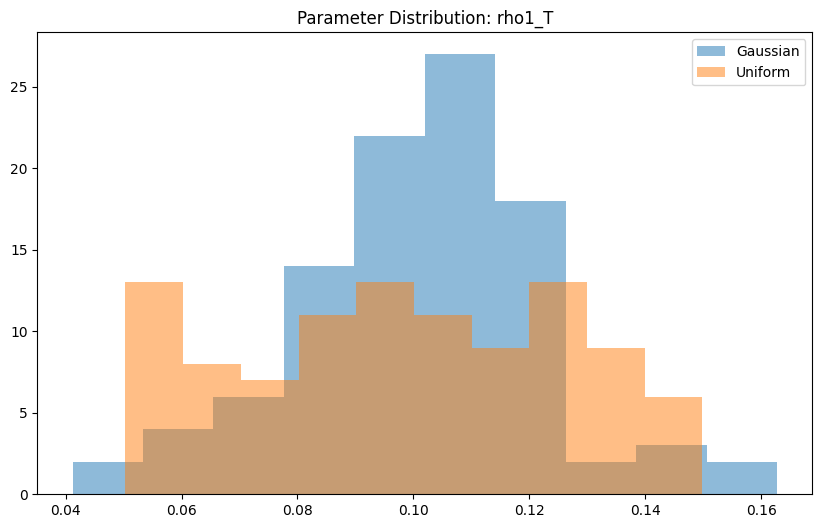

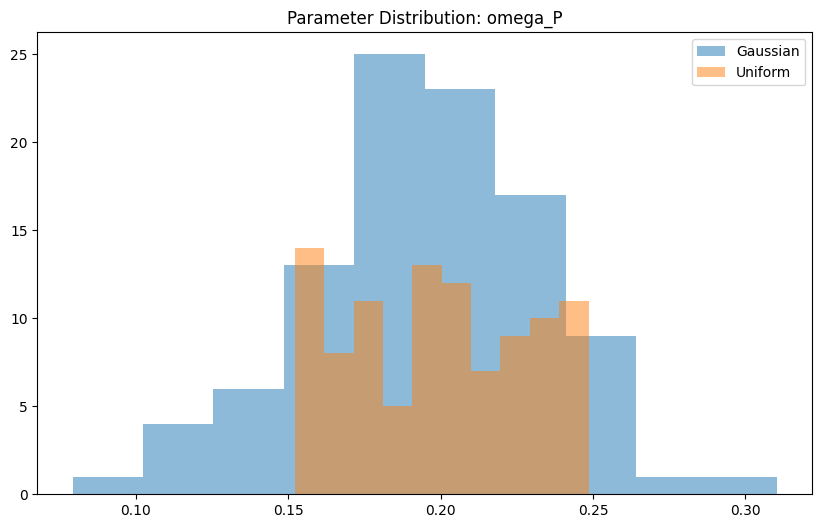

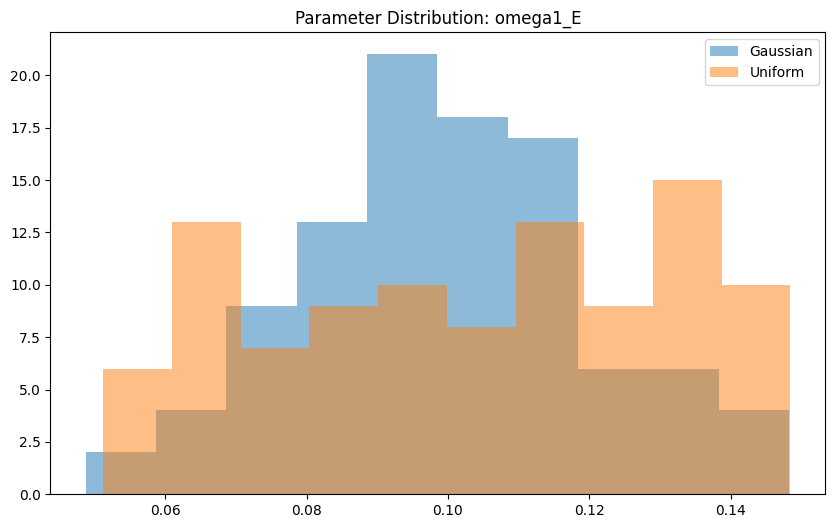


Metrics Comparison:

Gaussian:
MSE: 0.000002
RMSE: 0.001554
MAE: 0.001292
R2: 0.999997

Uniform:
MSE: 0.000003
RMSE: 0.001602
MAE: 0.001289
R2: 0.999995


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import minimize, least_squares

def model_forest_biomass(X, t, params):
    """
    Model diferensial untuk dinamika biomassa hutan
    """
    Y = np.zeros(7)
    
    # Unpack parameters
    s_B, alpha_BW, beta1_BN, beta2_BkuadratH, rho2_BT, rBW, v1_WN, v2_WH, thetaN, \
    lambda_beta1_BN, sigma_NW, phi_N, phi0_p, phi1_EP, gamma_N, pi_beta2_BkuadratH, \
    phi2_P, gamma1_H, rho, rho1_T, omega_P, omega1_E = params
    
    # Sistem persamaan diferensial
    Y[0] = -s_B*X[0] - alpha_BW*X[0]*X[1] - beta1_BN*X[0]*X[2] - beta2_BkuadratH*X[0]*X[0]*X[4] + rho2_BT*X[0]*X[5]
    Y[1] = rBW*X[1]*(1 - X[1]/X[0]) - v1_WN*X[1]*X[2] - v2_WH*X[1]*X[4]
    Y[2] = thetaN*X[2]*(1 - X[2]) + lambda_beta1_BN*X[0]*X[2] - sigma_NW*X[2]*X[1]
    Y[3] = phi_N*X[2] - phi0_p*X[3] - phi1_EP*X[3]*X[6]
    Y[4] = gamma_N*X[2] + pi_beta2_BkuadratH*X[0]*X[0]*X[4] + phi2_P*X[3] - gamma1_H*X[4]
    Y[5] = rho*(1 - X[0]) - rho1_T*X[5]
    Y[6] = omega_P*X[3] - omega1_E*X[6]
    
    return Y

def generate_gaussian_params(n_samples=100):
    """Generate synthetic parameter data using Gaussian distribution"""
    np.random.seed(42)
    
    param_means = [
        0.1,  # s_B
        0.2,  # alpha_BW
        0.15, # beta1_BN
        0.1,  # beta2_BkuadratH
        0.15, # rho2_BT
        0.3,  # rBW
        0.1,  # v1_WN
        0.1,  # v2_WH
        0.2,  # thetaN
        0.1,  # lambda_beta1_BN
        0.15, # sigma_NW
        0.2,  # phi_N
        0.1,  # phi0_p
        0.1,  # phi1_EP
        0.15, # gamma_N
        0.1,  # pi_beta2_BkuadratH
        0.1,  # phi2_P
        0.2,  # gamma1_H
        0.3,  # rho
        0.1,  # rho1_T
        0.2,  # omega_P
        0.1   # omega1_E
    ]
    
    param_stds = [mean * 0.2 for mean in param_means]
    
    params_data = np.zeros((n_samples, len(param_means)))
    for i in range(len(param_means)):
        params_data[:, i] = np.maximum(0.01, np.random.normal(
            param_means[i], 
            param_stds[i], 
            n_samples
        ))
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

def generate_uniform_params(n_samples=100):
    """Generate synthetic parameter data using Uniform distribution"""
    np.random.seed(42)
    
    # Range parameter berdasarkan batasan fisik dan literatur
    param_ranges = [
        (0.05, 0.15),   # s_B: laju pertumbuhan biomassa
        (0.1, 0.3),     # alpha_BW: laju predasi satwa
        (0.1, 0.2),     # beta1_BN: laju interaksi biomassa-manusia
        (0.05, 0.15),   # beta2_BkuadratH: laju kerusakan oleh aktivitas manusia
        (0.1, 0.2),     # rho2_BT: laju pemulihan oleh teknologi
        (0.2, 0.4),     # rBW: laju pertumbuhan satwa
        (0.05, 0.15),   # v1_WN: laju interaksi satwa-manusia
        (0.05, 0.15),   # v2_WH: laju pengurangan satwa oleh aktivitas
        (0.15, 0.25),   # thetaN: laju pertumbuhan populasi
        (0.05, 0.15),   # lambda_beta1_BN: faktor penguatan interaksi B-N
        (0.1, 0.2),     # sigma_NW: laju interaksi manusia-satwa
        (0.15, 0.25),   # phi_N: laju tekanan populasi
        (0.05, 0.15),   # phi0_p: laju pengurangan tekanan alami
        (0.05, 0.15),   # phi1_EP: laju pengurangan tekanan ekonomi
        (0.1, 0.2),     # gamma_N: laju peningkatan aktivitas oleh populasi
        (0.05, 0.15),   # pi_beta2_BkuadratH: faktor penguatan kerusakan
        (0.05, 0.15),   # phi2_P: laju peningkatan aktivitas oleh tekanan
        (0.15, 0.25),   # gamma1_H: laju pengurangan aktivitas alami
        (0.25, 0.35),   # rho: laju pengembangan teknologi
        (0.05, 0.15),   # rho1_T: laju penurunan efektivitas teknologi
        (0.15, 0.25),   # omega_P: laju respons ekonomi
        (0.05, 0.15)    # omega1_E: laju penurunan efektivitas ekonomi
    ]
    
    params_data = np.zeros((n_samples, len(param_ranges)))
    
    for i in range(len(param_ranges)):
        params_data[:, i] = np.random.uniform(
            param_ranges[i][0],
            param_ranges[i][1],
            n_samples
        )
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    return pd.DataFrame(params_data, columns=param_names), param_ranges

def objective_function(params, t, observed_data):
    """Fungsi objektif untuk optimasi"""
    X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
    solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
    return np.ravel(solution - observed_data)

def calculate_fitting_metrics(original, fitted):
    """Menghitung metrik kualitas fitting"""
    mse = np.mean((original - fitted)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(original - fitted))
    r2 = 1 - np.sum((original - fitted)**2) / np.sum((original - np.mean(original))**2)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def plot_fitting_error(t, original, fitted, method_name):
    """Plot error fitting"""
    error = np.abs(original - fitted)
    plt.figure(figsize=(10, 6))
    plt.plot(t, error)
    plt.title(f'Fitting Error - {method_name}')
    plt.xlabel('Time')
    plt.ylabel('Absolute Error')
    plt.grid(True)
    plt.show()

def plot_parameter_correlation(params, method_name):
    """Plot correlation matrix parameter"""
    corr = params.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f'Parameter Correlation Matrix - {method_name}')
    plt.show()

def plot_parameter_distributions(gaussian_params, uniform_params):
    """Plot perbandingan distribusi parameter"""
    for param in gaussian_params.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(gaussian_params[param], alpha=0.5, label='Gaussian')
        plt.hist(uniform_params[param], alpha=0.5, label='Uniform')
        plt.title(f'Parameter Distribution: {param}')
        plt.legend()
        plt.show()

def plot_with_confidence(solutions, times, variable_idx, method_name):
    """Plot time series dengan confidence interval"""
    mean = np.mean(solutions, axis=0)
    std = np.std(solutions, axis=0)
    plt.fill_between(times, mean-2*std, mean+2*std, alpha=0.2)
    plt.plot(times, mean, label=f'{method_name} Mean')

def run_analysis():
    """Fungsi utama untuk menjalankan analisis"""
    # Set parameter simulasi
    t = np.linspace(0, 100, 1000)
    X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
    
    # Generate parameter
    gaussian_params = generate_gaussian_params(n_samples=100)
    uniform_params, param_ranges = generate_uniform_params(n_samples=100)
    
    # Simulasi untuk kedua metode
    results = {}
    for method, params in [("Gaussian", gaussian_params.iloc[0].values),
                         ("Uniform", uniform_params.iloc[0].values)]:
        # Generate solusi original
        original_solution = odeint(model_forest_biomass, X0, t, args=(tuple(params),))
        
        # Tambah noise
        np.random.seed(42)
        noise_level = 0.02
        observed_data = original_solution + noise_level * np.random.randn(*original_solution.shape)
        observed_data = np.maximum(observed_data, 0)
        
        # Fitting
        result = least_squares(objective_function, 
                             params, 
                             args=(t, observed_data),
                             bounds=([0.001]*len(params), [np.inf]*len(params)))
        
        fitted_solution = odeint(model_forest_biomass, X0, t, args=(tuple(result.x),))
        
        # Hitung metrics
        metrics = calculate_fitting_metrics(original_solution, fitted_solution)
        
        # Plot hasil
        variables = ['Forest Biomass', 'Wildlife', 'Human Population', 
                    'Population Pressure', 'Human Activities',
                    'Technological Efforts', 'Economic Measures']
        
        plt.figure(figsize=(20, 15))
        for i in range(7):
            plt.subplot(3, 3, i+1)
            plt.plot(t, original_solution[:, i], 'r-', label='Original')
            plt.plot(t, observed_data[:, i], 'b.', label='Observed', alpha=0.3)
            plt.plot(t, fitted_solution[:, i], 'g--', label='Fitted')
            plt.xlabel('Time')
            plt.ylabel(variables[i])
            plt.title(f'{method} - {variables[i]}')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Plot error
        plot_fitting_error(t, original_solution, fitted_solution, method)
        
        # Simpan hasil
        results[method] = {
            'original': original_solution,
            'observed': observed_data,
            'fitted': fitted_solution,
            'metrics': metrics,
            'params': result.x
        }
    
    # Plot correlation matrix
    plot_parameter_correlation(gaussian_params, "Gaussian")
    plot_parameter_correlation(uniform_params, "Uniform")
    
    # Plot parameter distributions
    plot_parameter_distributions(gaussian_params, uniform_params)
    
    # Print metrics comparison
    print("\nMetrics Comparison:")
    for method in results:
        print(f"\n{method}:")
        for metric, value in results[method]['metrics'].items():
            print(f"{metric}: {value:.6f}")

if __name__ == "__main__":
    run_analysis() 